# Телекоммуникации

***Цель исследования:*** Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

Значение метрики качества *ROC-AUC* должно быть не меньше 0.85.

**Описание данных:** Данные состоят из нескольких файлов, полученных из разных источников:

`contract_new.csv` - информация о договоре:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

`personal_new.csv` - персональные данные клиента:
- `customerID` — идентификатор абонента;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

`internet_new.csv` - информация об интернет-услугах:
- `customerID` — идентификатор абонента;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

`phone_new.csv` - информация об услугах телефонии:
- `customerID` — идентификатор абонента;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года (дата выгшрузки датасетов).

**Описание услуг:** Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно (столбец `MultipleLines` в `phone_new.csv`).
- Интернет. Подключение может быть двух типов (`InternetService`): через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны услуги, описанные в `internet_new.csv`.

***Ход исследования:*** Планируется 3 этапа:
1. Загрузка данных.
2. Исследовательский анализ и предобработка данных. 
3. Объединение данных.
4. Исследовательский анализ и предобработка данных объединённого датафрейма.
5. Подготовка данных.
6. Обучение моделей машинного обучения.
7. Выбор лучшей модели.
8. Общий вывод и рекомендации заказчику.

In [1]:
# Импортируем необходимые библиотеки и методы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

RANDOM_STATE = 100225
TEST_SIZE = 0.25

## Загрузка данных

In [2]:
# Откроем и изучим contract_new.csv.
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
except:
    contract = pd.read_csv('https://(хранилище датасетов яндекс)/datasets/contract_new.csv')

contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contract.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


**Промежуточный вывод:** Видим данные о договорах клиентов. Данные соответствуют описанию задачи, однако не все типы данных верные. Обзор методом info() не выявил пропуски.

In [5]:
# Откроем и изучим personal_new.csv.
try:
    personal = pd.read_csv('/datasets/personal_new.csv')
except:
    personal = pd.read_csv('https://(хранилище датасетов яндекс)/datasets/personal_new.csv')

personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
personal.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


**Промежуточный вывод:** Видим персональные данные клиентов. Данные соответствуют описанию задачи, однако не все типы данных верные. Обзор методом info() не выявил пропуски.

In [8]:
# Откроем и изучим internet_new.csv.
try:
    internet = pd.read_csv('/datasets/internet_new.csv')
except:
    internet = pd.read_csv('https://(хранилище датасетов яндекс)/datasets/internet_new.csv')

internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


**Промежуточный вывод:** Видим данные об интернет-услугах клиентов. Данные соответствуют описанию задачи, однако не все типы данных верные. Обзор методом info() не выявил пропуски. Стоит отметить, что не каждый абонент «ТелеДома» пользуется интернет-услугами.

In [11]:
# Откроем и изучим phone_new.csv.
try:
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    phone = pd.read_csv('https://(хранилище датасетов яндекс)/datasets/phone_new.csv')

phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [12]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [13]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


**Промежуточный вывод:** Видим данные об услугах телефонии клиентов. Данные соответствуют описанию задачи, однако не все типы данных верные. Обзор методом info() не выявил пропуски. Стоит отметить, что не каждый абонент «ТелеДома» пользуется услугами телефонии.

## Исследовательский анализ и предобработка данных

### Первичная предобработка

In [14]:
# Проверим датафреймы на явные дубликаты.
contract.duplicated().sum()

0

In [15]:
personal.duplicated().sum()

0

In [16]:
internet.duplicated().sum()

0

In [17]:
phone.duplicated().sum()

0

In [18]:
# Проверим датафреймы на неявные дубликаты и опечатки.
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [19]:
contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [20]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [21]:
# Зададим целевой признак - разрыв договора - отдельно.
contract['terminated'] = 1
contract.loc[contract['EndDate'] == 'No', 'terminated'] = 0

In [22]:
# Преобразуем даты начала и конца договора. Создадим новый признак - длительность договора в днях.
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')
contract['duration'] = contract['EndDate'] - contract['BeginDate']
contract['duration'] = contract['duration'].dt.days

In [23]:
# Сами столбцы начала и конца договора удалим - они могут вызвать утечку данных при обучении моделей.
contract = contract.drop(['BeginDate', 'EndDate'], axis=1)

In [24]:
# Приведём TotalCharges к правильному типу.
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [25]:
# Проверим TotalCharges на пропуски ещё раз.
contract['TotalCharges'].isna().sum()

11

In [26]:
# Уберём пропуски. Их количество незначительно и им можно принебречь.
contract = contract.dropna(subset = ['TotalCharges'])

In [27]:
# Зададим ещё 2 новых признака - использование абонентом интернета и телефона - в соответствующие
# датафреймы. Они понадобятся в дальнейшем.
internet['internet'] = 'Yes'
phone['phone'] = 'Yes'

**Промежуточный вывод:** В результате предобработки данных сгенерировали 2 новых признака взамен 2 старых: один из них - целевой(terminated - состояние договора), другой(duration - длительность договора) объединяет в себе два старых признака для более удобного анализа. Также добавили 2 признака использования абонентом интернета и телефона для дальнейшей работы с объединённым датафреймом.

### Исследование contract_new.csv

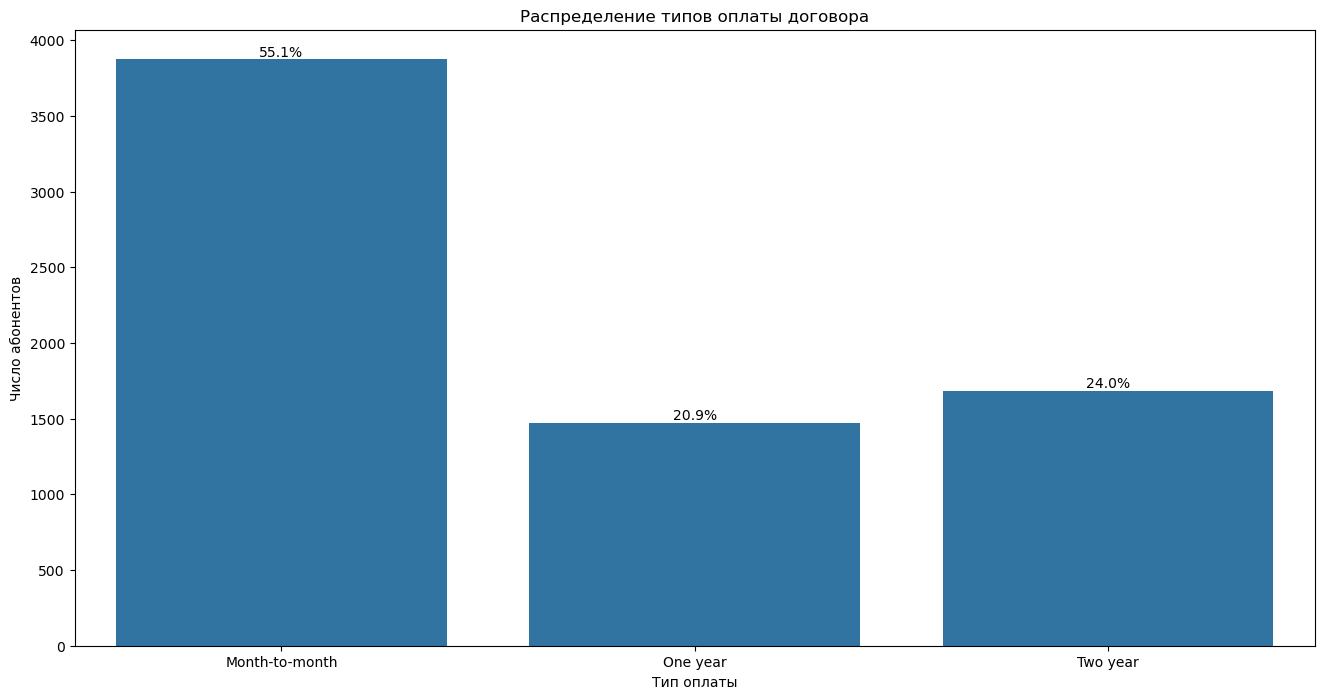

In [28]:
# Построим графики для количественных признаков датафрейма.
# Построим столбчатую диаграмму распределения типов оплаты договора.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='Type', data = contract)
total = contract['Type'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Распределение типов оплаты договора')
plt.xlabel('Тип оплаты')
plt.ylabel('Число абонентов')
plt.show()

**Описание данных:** Видим, что оплачивающих каждый месяц больше, чем раз в год-два.

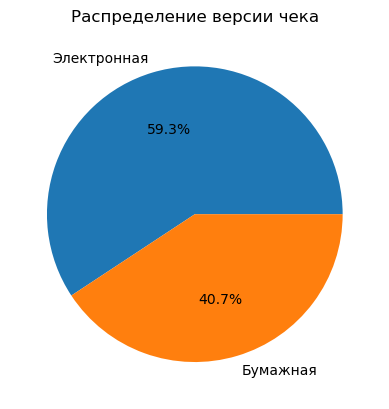

In [29]:
# Построим круговую диаграмму распределения бумажной и электронной версии чека.
labels = ['Электронная','Бумажная']
data = contract['PaperlessBilling'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Распределение версии чека')
plt.show()

**Описание данных:** Видим, что абонентов, получающих электронный чек больше, чем бумажный.

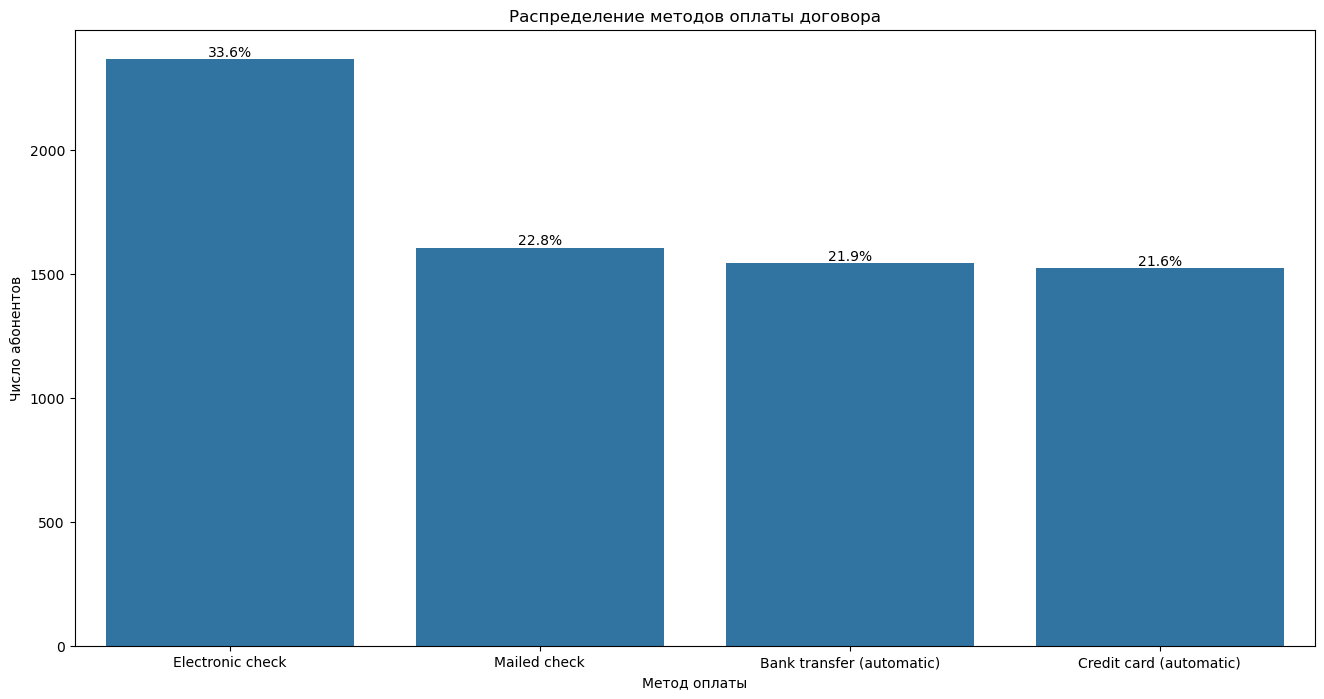

In [30]:
# Построим столбчатую диаграмму распределения методов оплаты договора.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='PaymentMethod', data = contract)
total = contract['PaymentMethod'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Распределение методов оплаты договора')
plt.xlabel('Метод оплаты')
plt.ylabel('Число абонентов')
plt.show()

**Описание данных:** Видим, что оплачивающих по квитанции онлайн больше, чем оплачивающих вживую или автоматическими переводами из банка или по карте.

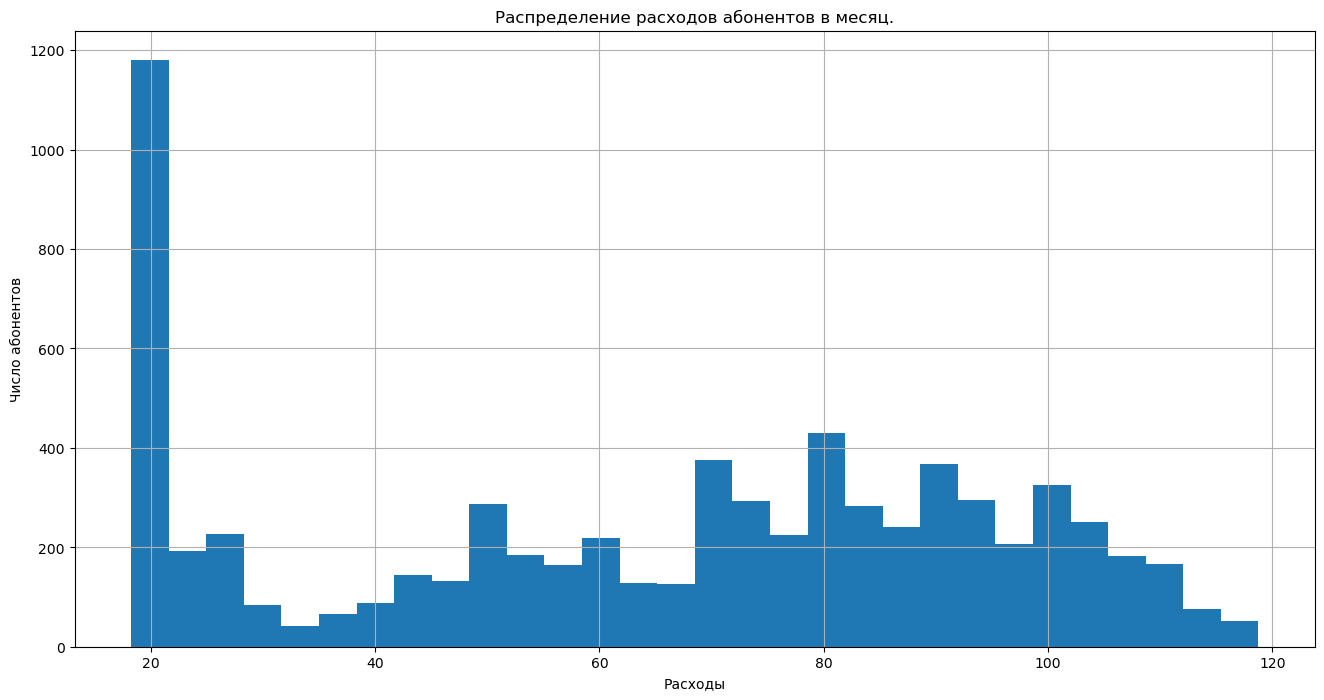

In [31]:
# Построим гистограмму распределения расходов абонентов в месяц.
contract['MonthlyCharges'].hist(figsize=(16, 8), bins=30)
plt.title('Распределение расходов абонентов в месяц.')
plt.xlabel('Расходы')
plt.ylabel('Число абонентов')
plt.show()

**Описание данных:** Видим распределение, не вызывающие подозрений. Отметим, что большинство абонентов пользуются минимальными по стоимости услугами оператора.

In [32]:
# Построим гистограмму распределения общих расходов абонентов.
contract['TotalCharges'].describe()

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64

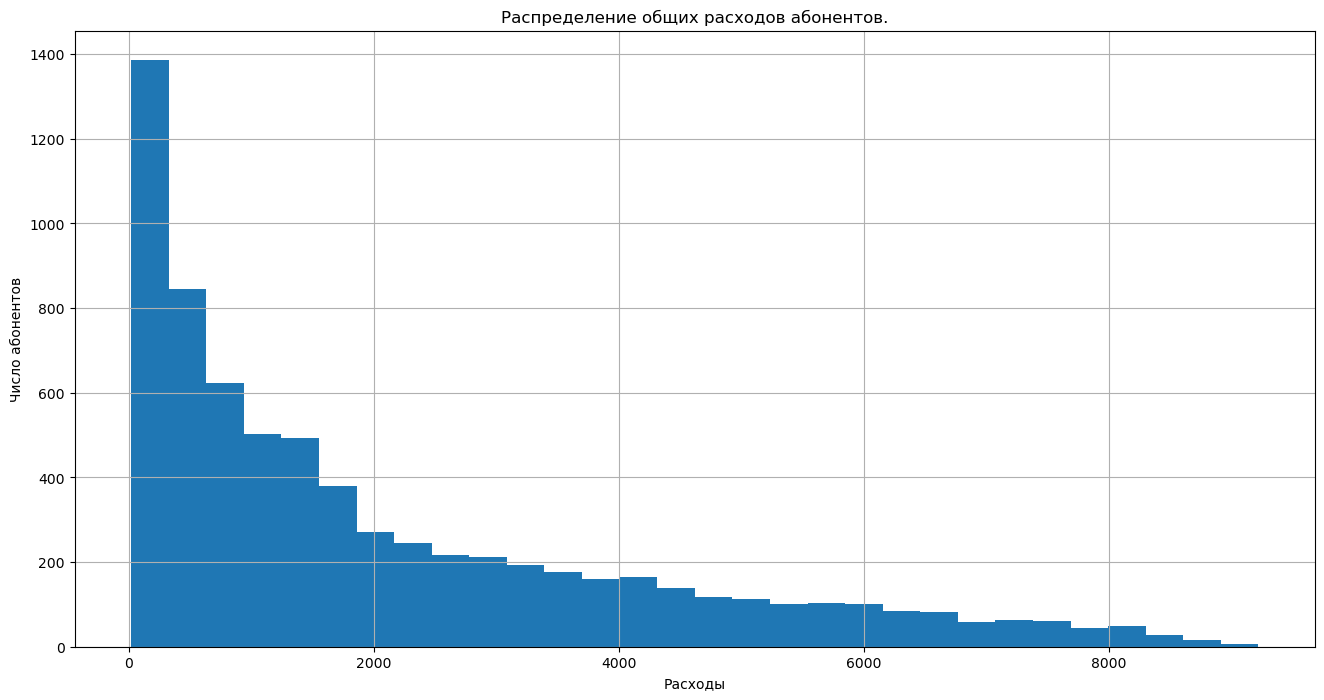

In [33]:
contract['TotalCharges'].hist(figsize=(16, 8), bins=30)
plt.title('Распределение общих расходов абонентов.')
plt.xlabel('Расходы')
plt.ylabel('Число абонентов')
plt.show()

**Описание данных:** Видим распределение, не вызывающие подозрений. Большое количество минимальных общих расходов объясняется большим количеством минимальных месячных, а более плавное распределение, чем месячное - притоком новых абонентов.

In [34]:
# Построим гистограмму распределения длительности договора.
contract['duration'].describe()

count    7032.000000
mean      899.961320
std       682.738777
min        28.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: duration, dtype: float64

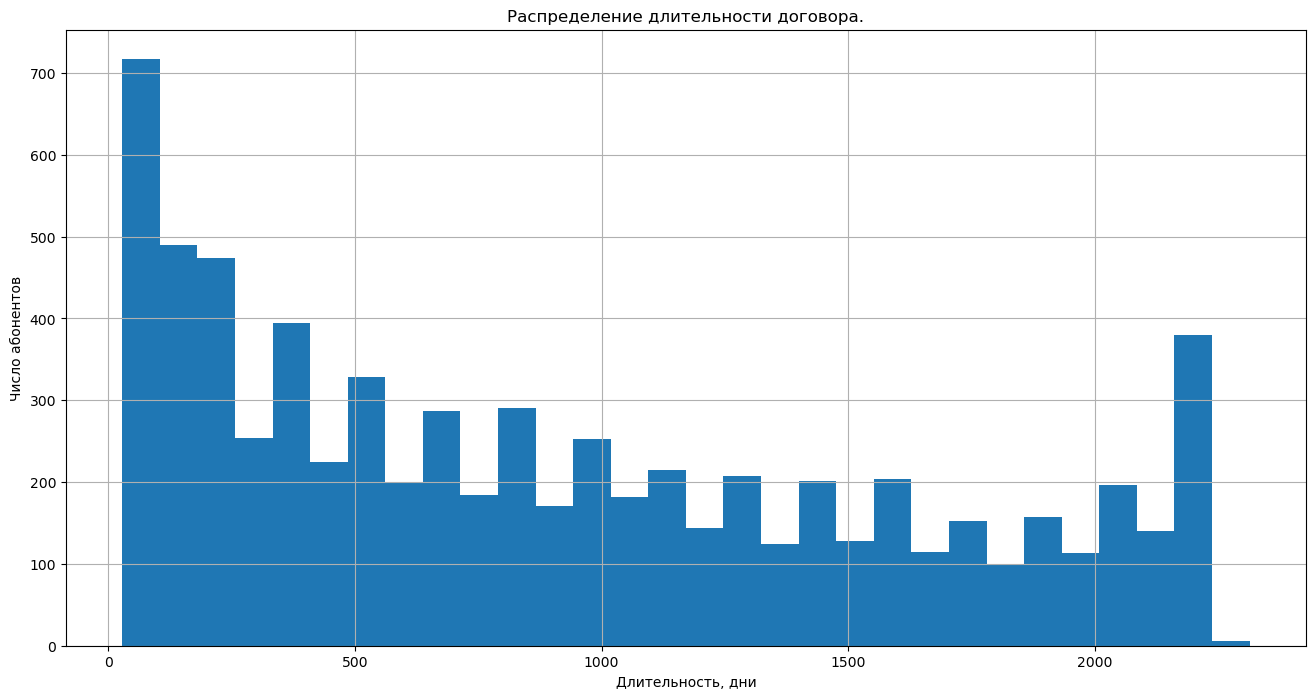

In [35]:
contract['duration'].hist(figsize=(16, 8), bins=30)
plt.title('Распределение длительности договора.')
plt.xlabel('Длительность, дни')
plt.ylabel('Число абонентов')
plt.show()

**Описание данных:** Видим распределение длительности. Выброс у конца можно объяснить приходом оператора на рынок. С выбросом ближе к началу сложнее.

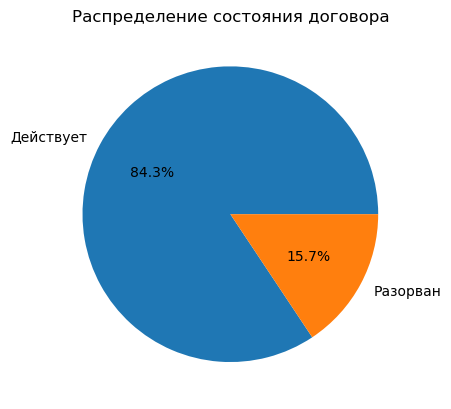

In [36]:
# Построим круговую диаграмму распределения целевого признака - состояния договора.
labels = ['Действует','Разорван']
data = contract['terminated'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Распределение состояния договора')
plt.show()

**Описание данных:** Видим, что контракт разрывают 15.7% абонентов, остальные остаются с оператором.

### Исследование personal_new.csv

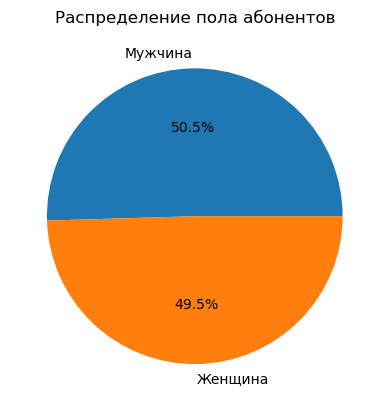

In [37]:
# Построим круговую диаграмму распределения пола абонентов.
labels = ['Мужчина','Женщина']
data = personal['gender'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Распределение пола абонентов')
plt.show()

**Описание данных:** Видим, что абоненты распределены по полу практически поровну.

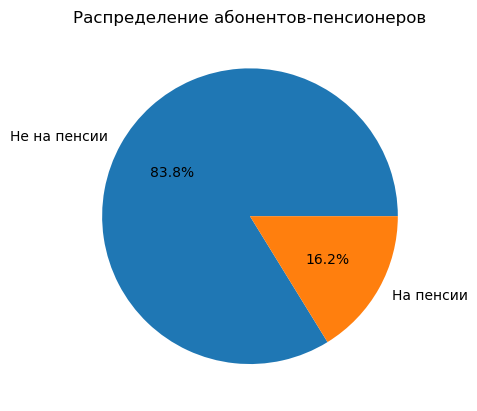

In [38]:
# Построим круговую диаграмму распределения абонентов-пенсионеров.
labels = ['Не на пенсии','На пенсии']
data = personal['SeniorCitizen'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Распределение абонентов-пенсионеров')
plt.show()

**Описание данных:** Видим, что на пенсии находится 16.2% абонентов.

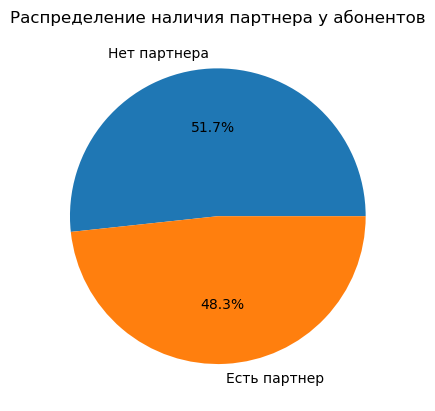

In [39]:
# Построим круговую диаграмму распределения наличия партнера у абонентов.
labels = ['Нет партнера','Есть партнер']
data = personal['Partner'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Распределение наличия партнера у абонентов')
plt.show()

**Описание данных:** Видим, что абоненты распределены по наличию партнера практически поровну.

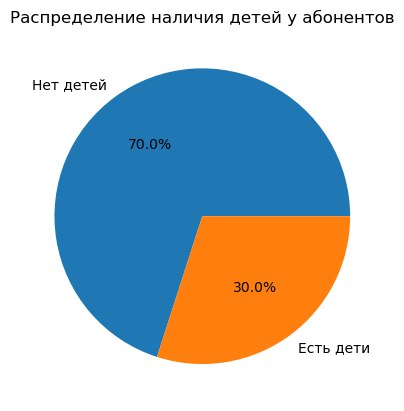

In [40]:
# Построим круговую диаграмму распределения наличия детей у абонентов.
labels = ['Нет детей','Есть дети']
data = personal['Dependents'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Распределение наличия детей у абонентов')
plt.show()

**Описание данных:** Видим, что дети есть у 30% абонентов.

### Исследование internet_new.csv

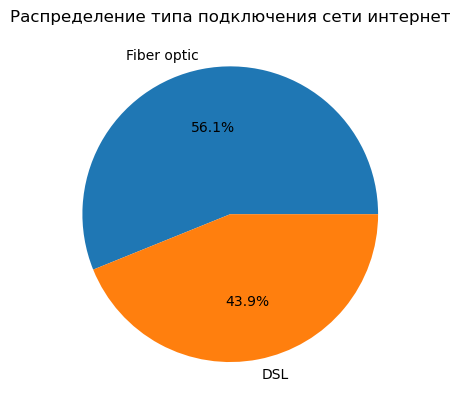

In [41]:
# Построим круговую диаграмму распределения типа подключения сети интернет абонентов.
labels = ['Fiber optic','DSL']
data = internet['InternetService'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Распределение типа подключения сети интернет')
plt.show()

**Описание данных:** Видим, что абоненты распределены по типу подключения сети интернет практически поровну, с небольшим перевесом в пользу оптоволоконного.

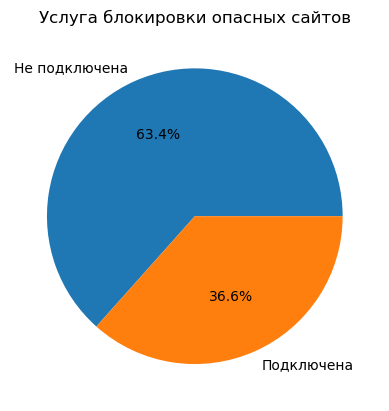

In [42]:
# Построим круговую диаграмму распределения использования услуги блокировки опасных сайтов.
labels = ['Не подключена','Подключена']
data = internet['OnlineSecurity'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Услуга блокировки опасных сайтов')
plt.show()

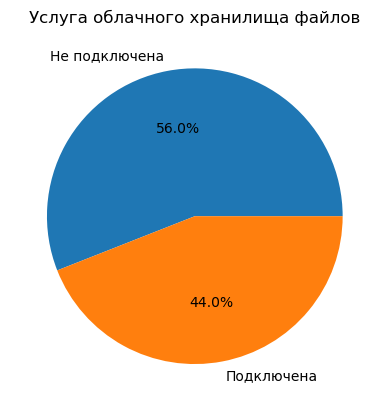

In [43]:
# Построим круговую диаграмму распределения использования услуги облачного хранилища файлов.
labels = ['Не подключена','Подключена']
data = internet['OnlineBackup'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Услуга облачного хранилища файлов')
plt.show()

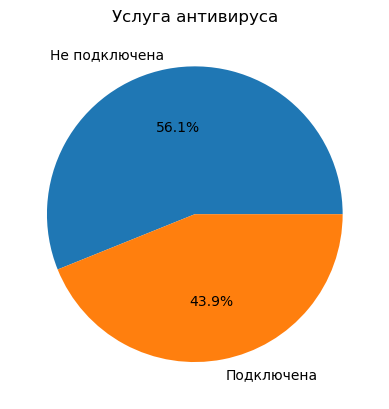

In [44]:
# Построим круговую диаграмму распределения использования услуги антивируса.
labels = ['Не подключена','Подключена']
data = internet['DeviceProtection'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Услуга антивируса')
plt.show()

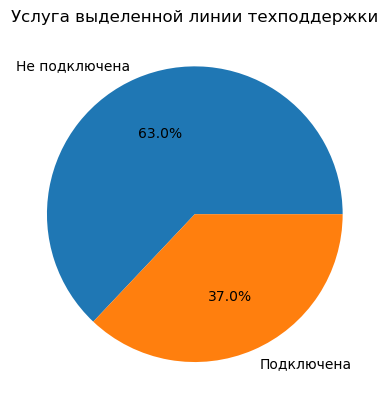

In [45]:
# Построим круговую диаграмму распределения использования услуги выделенной линии техподдержки.
labels = ['Не подключена','Подключена']
data = internet['TechSupport'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Услуга выделенной линии техподдержки')
plt.show()

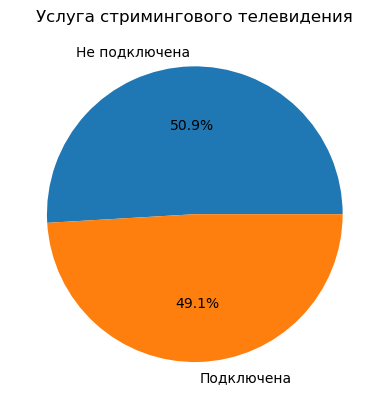

In [46]:
# Построим круговую диаграмму распределения использования услуги стримингового телевидения.
labels = ['Не подключена','Подключена']
data = internet['StreamingTV'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Услуга стримингового телевидения')
plt.show()

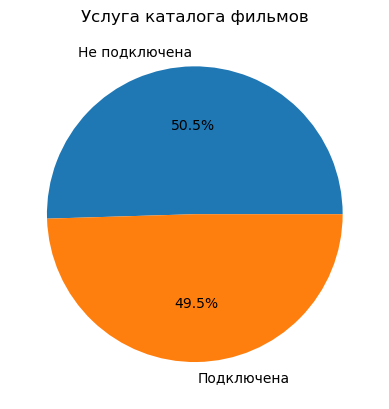

In [47]:
# Построим круговую диаграмму распределения использования услуги каталога фильмов.
labels = ['Не подключена','Подключена']
data = internet['StreamingMovies'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Услуга каталога фильмов')
plt.show()

**Описание данных:** Видим распределения пользования интернет-услугами оператора абонентами. Ни одна из услуг не подключена более чем половиной абонентов.

### Исследование phone_new.csv

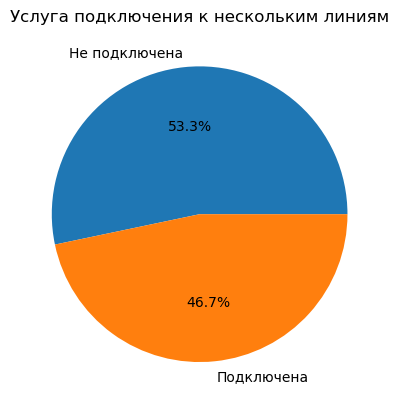

In [48]:
# Построим круговую диаграмму распределения подключения телефона к нескольким линиям одновременно.
labels = ['Не подключена','Подключена']
data = phone['MultipleLines'].value_counts()
plt.pie(x=data, autopct="%.1f%%", labels=labels)
plt.title('Услуга подключения к нескольким линиям')
plt.show()

**Описание данных:** Видим, что услуга подключена у 46.7% абонентов.

**Промежуточный вывод:** В целом данные не выглядят подозрительно. Тем не менее, их всё ещё надо кодировать и масштабировать. На лицо несбалансированность целевого признака, что нужно учитывать в дальнейшей работе.

## Объединение данных

In [49]:
# Объединим наши датафреймы в один.
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   terminated        7032 non-null   int64  
 7   duration          7032 non-null   int64  
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   int64  
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   5512 non-null   object 
 13  OnlineSecurity    5512 non-null   object 
 14  OnlineBackup      5512 non-null   object 
 15  DeviceProtection  5512 non-null   object 
 16  TechSupport       5512 non-null   object 


## Исследовательский анализ и предобработка данных объединённого датафрейма

### Предобработка данных

In [51]:
# Заполним пропуски, образовавшиеся при объединении датафреймов.
data[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
      'TechSupport', 'StreamingTV', 'StreamingMovies', 'internet',
      'MultipleLines', 'phone']] = data[['InternetService', 'OnlineSecurity',
                                         'OnlineBackup', 'DeviceProtection',
                                         'TechSupport', 'StreamingTV',
                                         'StreamingMovies', 'internet',
                                         'MultipleLines', 'phone']].fillna('None')

In [52]:
# Приведём названия столбцов датафрейма к змеиному регистру для дальнейшего удобства.
data = data.set_axis(['customer_id', 'type', 'paperless_billing',
                      'payment_method', 'monthly_charges', 'total_charges', 'terminated',
                      'duration', 'gender', 'senior_citizen', 'partner', 'dependents',
                      'internet_service', 'online_security', 'online_backup', 'device_protection',
                      'tech_support', 'streaming_tv', 'streaming_movies', 'internet',
                      'multiple_lines', 'phone'], axis=1)

data.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,terminated,duration,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,multiple_lines,phone
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,...,DSL,No,Yes,No,No,No,No,Yes,None,None
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,...,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,...,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,Yes,None,None
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,...,Fiber optic,No,No,No,No,No,No,Yes,No,Yes


In [53]:
# Добавим новый признак - пользуется ли абонент услугами оператора
# для телефона, для интернета или обеими.
data['both'] = 0
data.loc[data['phone'] == 'None', 'both'] = 1 
data.loc[data['internet'] == 'None', 'both'] = 2

**Промежуточный вывод:** Данные объединены в один датафрейм и готовы к дальнейшему анализу. Добавлены и дополнены новые признаки.

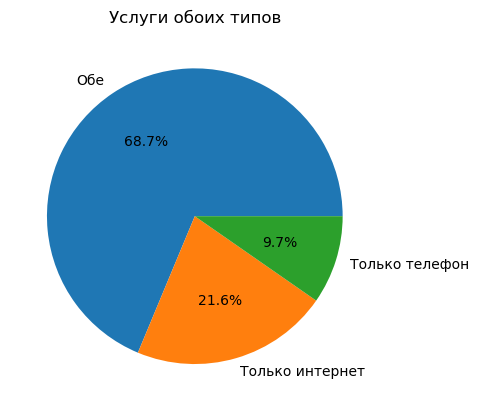

In [54]:
# Построим круговую диаграмму распределения использования абонентами услуг обоих типов.
labels = ['Обе','Только интернет', 'Только телефон']
xdata = data['both'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуги обоих типов')
plt.show()

**Описание данных:** Видим, что 68.7% абонентов пользуются услугами и интернета и телефонии.

### Портрет ушедшего абонента

Составим портрет ушедшего абонента. Так как разорванных договоров немного относительно общего числа, можем сравнить графический портрет с общим исследованием.

#### Общая информация

In [55]:
data_left = data.loc[data['terminated'] == 1]

In [56]:
pd.set_option('display.max_columns', None)
data_left.describe(include='all')

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,terminated,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,multiple_lines,phone,both
count,1101,1101,1101,1101,1101.000000,1101.000000,1101.0,1101.000000,1101,1101.000000,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101.000000
unique,1101,3,2,4,NaN,NaN,NaN,NaN,2,NaN,2,2,3,3,3,3,3,3,3,2,3,2,NaN
top,6388-TABGU,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,Male,NaN,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,NaN
freq,1,407,721,350,NaN,NaN,NaN,NaN,573,NaN,719,733,595,526,560,550,543,584,606,941,678,998,NaN
mean,NaN,NaN,NaN,NaN,75.546004,2371.377275,1.0,924.863760,NaN,0.210718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384196
std,NaN,NaN,NaN,NaN,29.116213,1581.862275,0.0,458.771309,NaN,0.408003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.726439
min,NaN,NaN,NaN,NaN,18.400000,77.840000,1.0,28.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,56.150000,1048.050000,1.0,577.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,84.200000,2139.030000,1.0,915.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,99.500000,3404.910000,1.0,1249.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


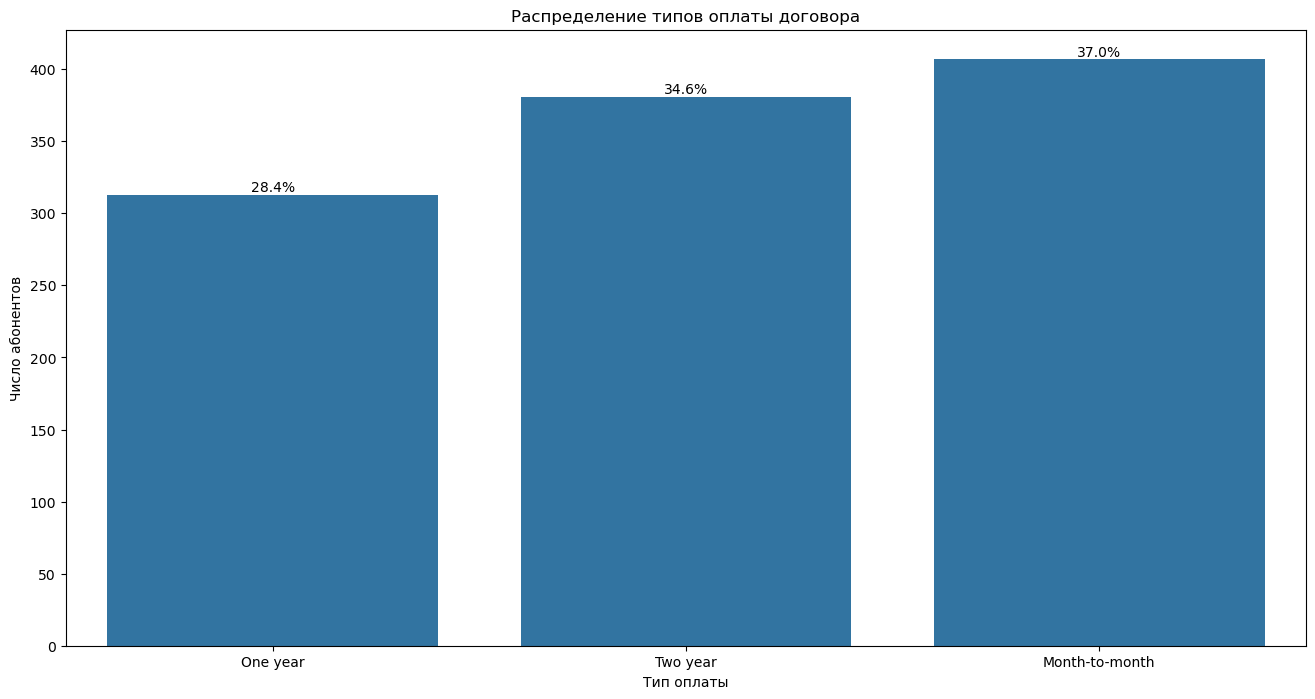

In [57]:
# Построим столбчатую диаграмму распределения типов оплаты договора.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='type', data = data_left)
total = data_left['type'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Распределение типов оплаты договора')
plt.xlabel('Тип оплаты')
plt.ylabel('Число абонентов')
plt.show()

**Описание данных:** Видим, что число оплачивавших договор каждый месяц ближе к другим типам оплаты.

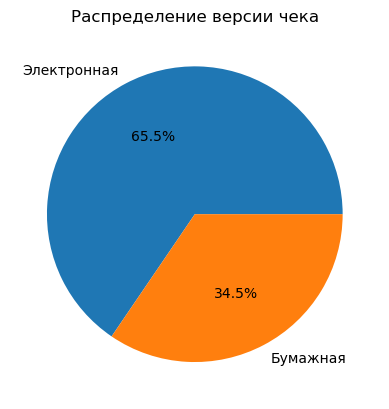

In [58]:
# Построим круговую диаграмму распределения бумажной и электронной версии чека.
labels = ['Электронная','Бумажная']
xdata = data_left['paperless_billing'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Распределение версии чека')
plt.show()

**Описание данных:** Видим, что число абонентов, получавших электронный чек, сместилось в большую сторону.

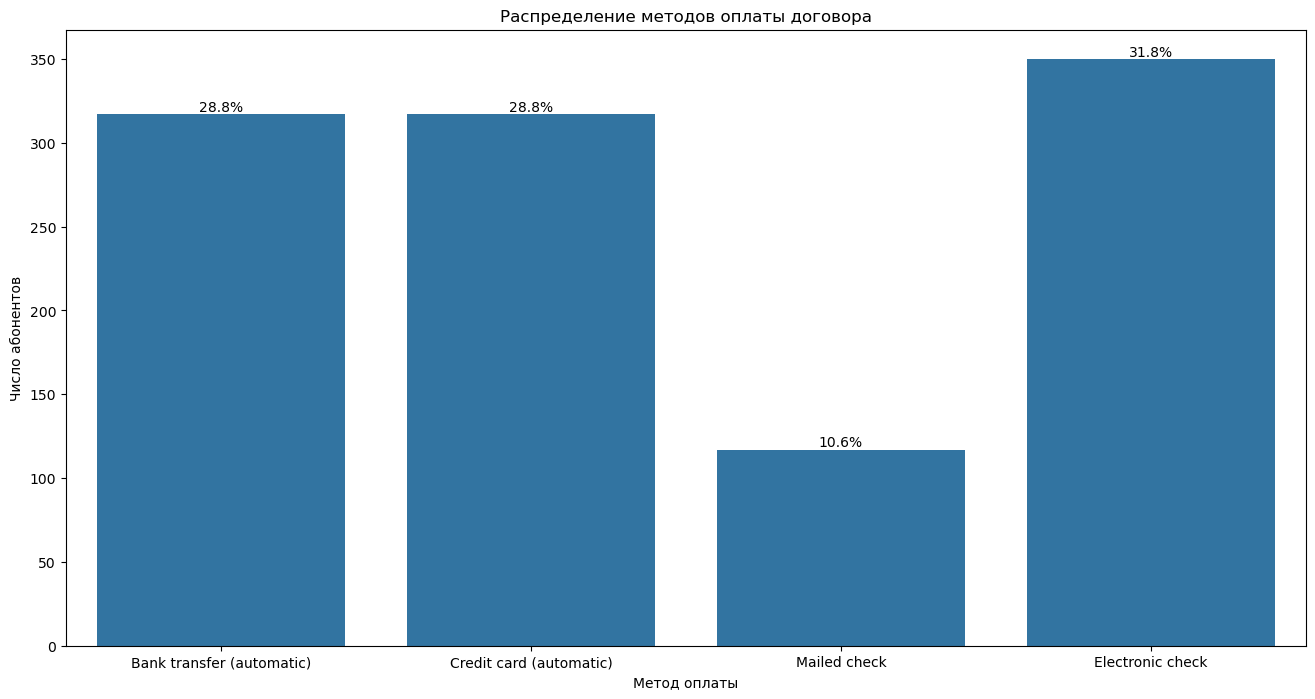

In [59]:
# Построим столбчатую диаграмму распределения методов оплаты договора.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='payment_method', data = data_left)
total = data_left['payment_method'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Распределение методов оплаты договора')
plt.xlabel('Метод оплаты')
plt.ylabel('Число абонентов')
plt.show()

**Описание данных:** Видим, что число оплачивавших по квитанции онлайн стало ближе к другим способам, а число оплачивавших вживую сильно упало.

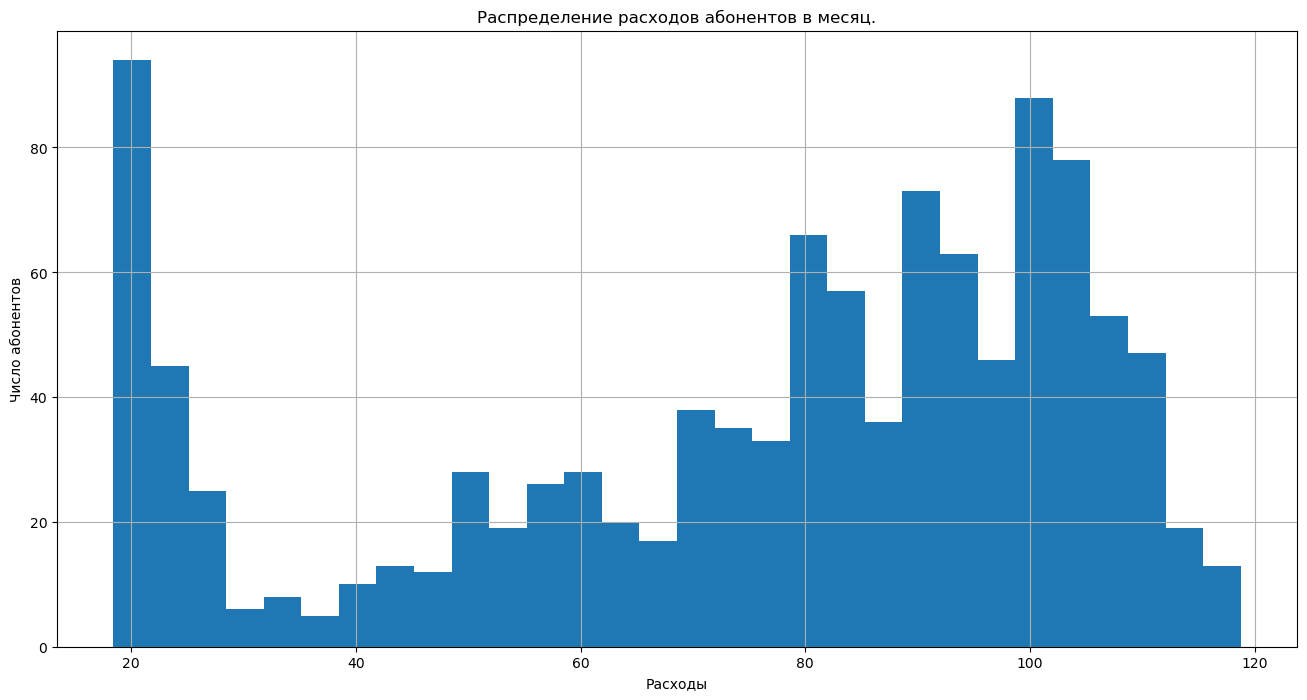

In [60]:
# Построим гистограмму распределения расходов абонентов в месяц.
data_left['monthly_charges'].hist(figsize=(16, 8), bins=30)
plt.title('Распределение расходов абонентов в месяц.')
plt.xlabel('Расходы')
plt.ylabel('Число абонентов')
plt.show()

**Описание данных:** Видим, что число ушедших абонентов с большими затратами выше среднего, а абонентов с минимальными тратами - заметно ниже.

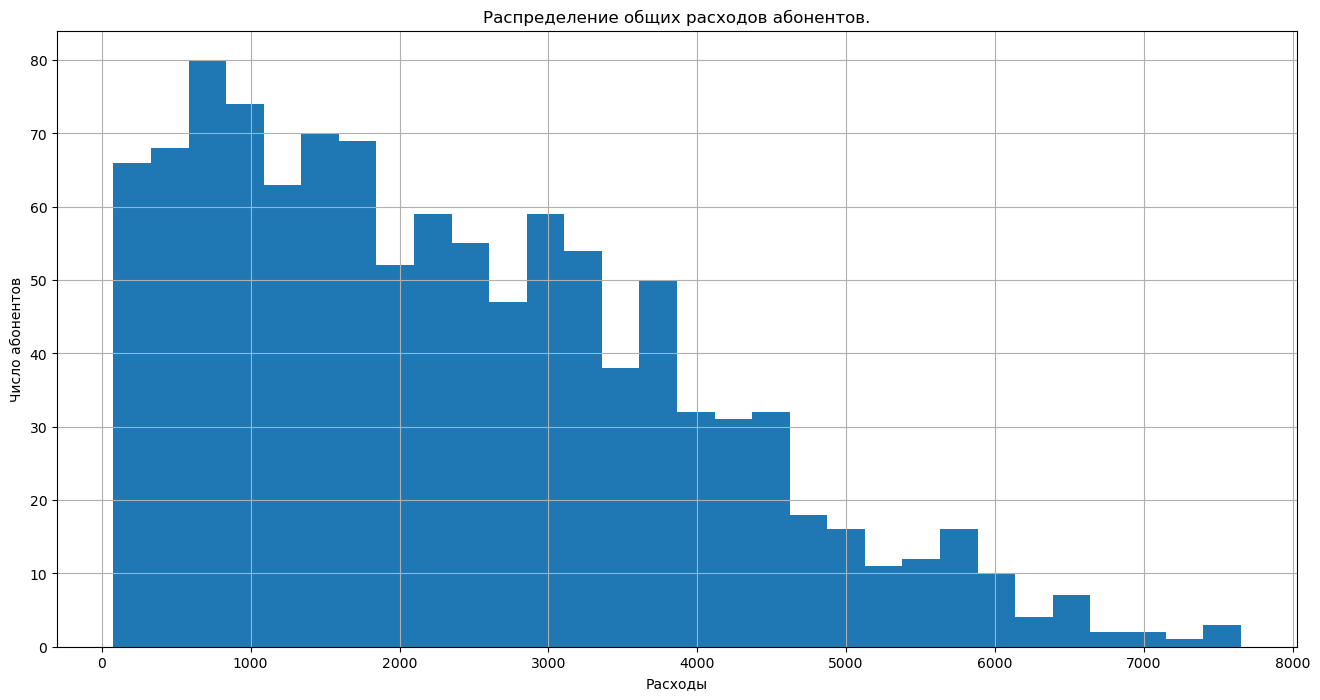

In [61]:
# Построим гистограмму распределения общих расходов абонентов.
data_left['total_charges'].hist(figsize=(16, 8), bins=30)
plt.title('Распределение общих расходов абонентов.')
plt.xlabel('Расходы')
plt.ylabel('Число абонентов')
plt.show()

**Описание данных:** Видим, что распределение расходов ушедших абонентов более плавное.

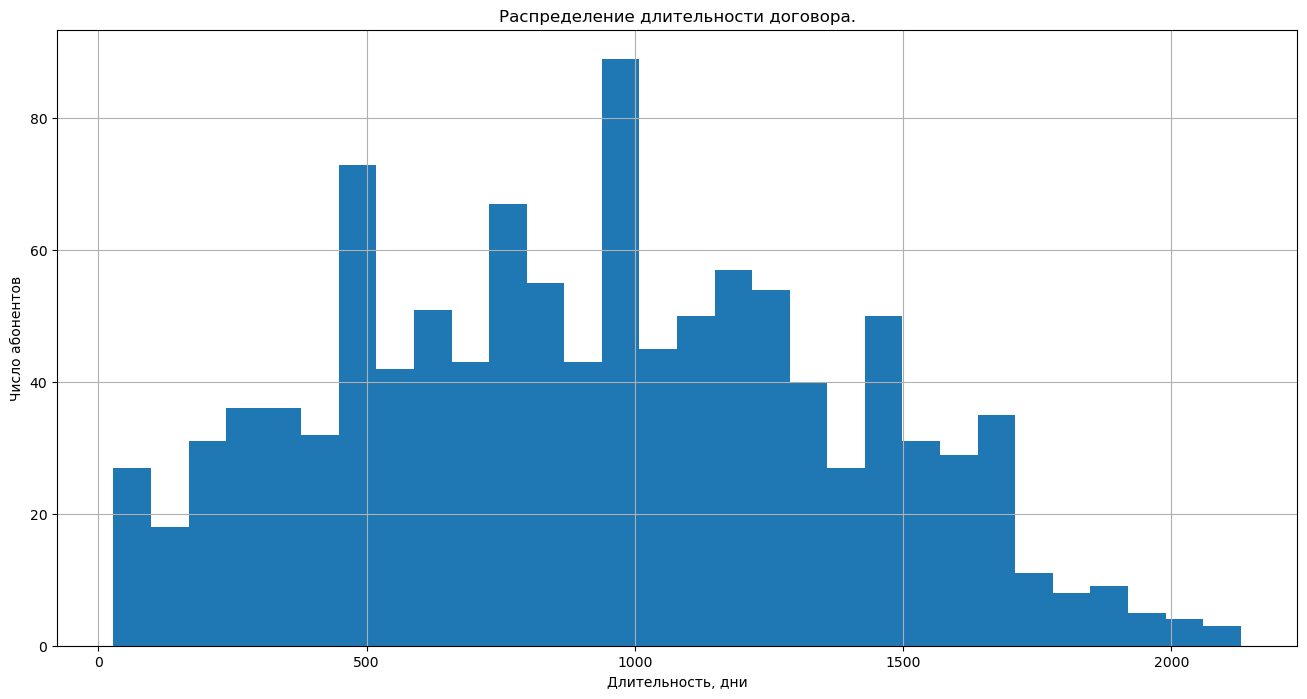

In [62]:
# Построим гистограмму распределения длительности договора.
data_left['duration'].hist(figsize=(16, 8), bins=30)
plt.title('Распределение длительности договора.')
plt.xlabel('Длительность, дни')
plt.ylabel('Число абонентов')
plt.show()

**Описание данных:** Видим, что отток клиентов не коррелирует с общим распределением длительности договора. Однако, он затрагивает много абонентов, пользующихся услугами дольше года.

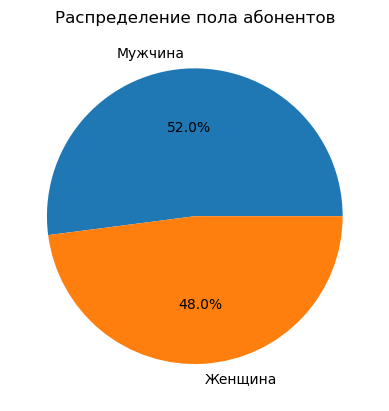

In [63]:
# Построим круговую диаграмму распределения пола абонентов.
labels = ['Мужчина','Женщина']
xdata = data_left['gender'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Распределение пола абонентов')
plt.show()

**Описание данных:** Видим, что распределение особо не изменилось.

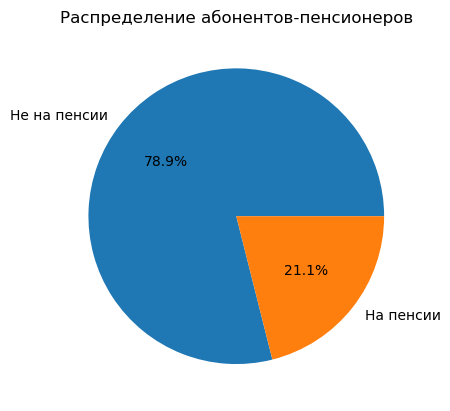

In [64]:
# Построим круговую диаграмму распределения абонентов-пенсионеров.
labels = ['Не на пенсии','На пенсии']
xdata = data_left['senior_citizen'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Распределение абонентов-пенсионеров')
plt.show()

**Описание данных:** Видим, что контракт расторгает больше среднего пенсионеров.

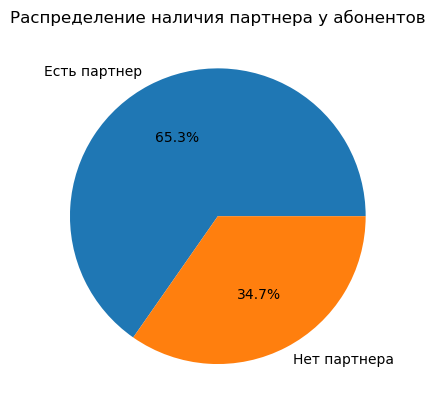

In [65]:
# Построим круговую диаграмму распределения наличия партнера у абонентов.
labels = ['Есть партнер','Нет партнера']
xdata = data_left['partner'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Распределение наличия партнера у абонентов')
plt.show()

**Описание данных:** Видим, что число ушедших абонентов с партнёром выше среднего.

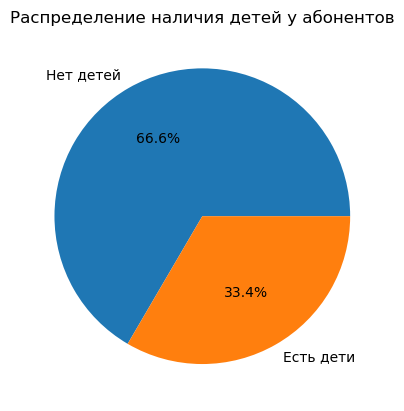

In [66]:
# Построим круговую диаграмму распределения наличия детей у абонентов.
labels = ['Нет детей','Есть дети']
xdata = data_left['dependents'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Распределение наличия детей у абонентов')
plt.show()

**Описание данных:** Видим, что распределение особо не изменилось.

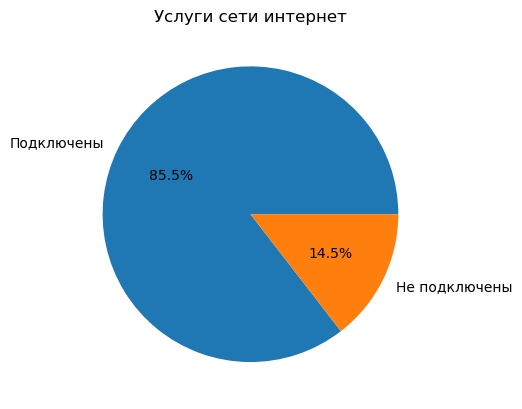

In [67]:
# Построим круговую диаграмму распределения использования абонентами услуг сети интернет.
labels = ['Подключены','Не подключены']
xdata = data_left['internet'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуги сети интернет')
plt.show()

**Описание данных:** Видим, что интернетом пользовалось большее среднего число ушедших абонентов.

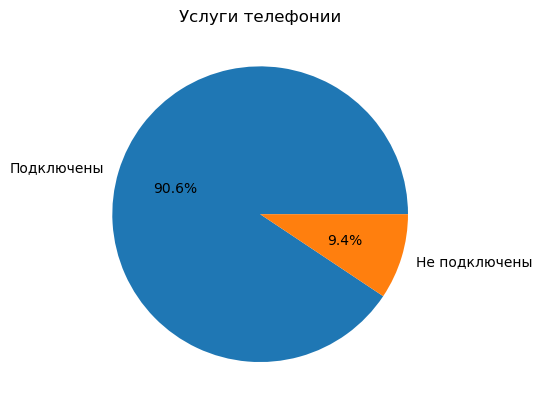

In [68]:
# Построим круговую диаграмму распределения использования абонентами услуг телефонии.
labels = ['Подключены','Не подключены']
xdata = data_left['phone'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуги телефонии')
plt.show()

**Описание данных:** Видим, что распределение особо не изменилось.

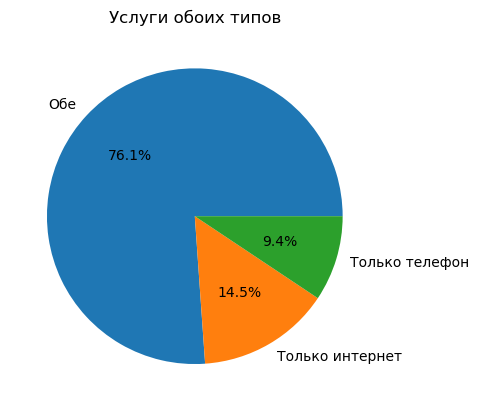

In [69]:
# Построим круговую диаграмму распределения использования абонентами услуг обоих типов.
labels = ['Обе','Только интернет', 'Только телефон']
xdata = data_left['both'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуги обоих типов')
plt.show()

**Описание данных:** Видим, что число ушедших абонентов, пользовавшихся услугами обоих типов выше среднего.

#### Интернет-услуги

In [70]:
internet_left = contract.merge(internet, on='customerID', how='left')
internet_left = internet_left.loc[internet_left['terminated'] == 1]
internet_left = internet_left.dropna()

In [71]:
internet_left.describe(include='all')

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,terminated,duration,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet
count,941,941,941,941,941.000000,941.000000,941.0,941.000000,941,941,941,941,941,941,941,941
unique,941,3,2,4,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,1
top,6388-TABGU,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
freq,1,403,672,341,NaN,NaN,NaN,NaN,595,526,560,550,543,584,606,941
mean,NaN,NaN,NaN,NaN,84.650638,2652.468799,1.0,917.602550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,20.492493,1536.694660,0.0,455.208002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,24.100000,80.950000,1.0,28.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,72.100000,1479.760000,1.0,578.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,89.100000,2511.250000,1.0,913.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,100.550000,3685.070000,1.0,1247.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


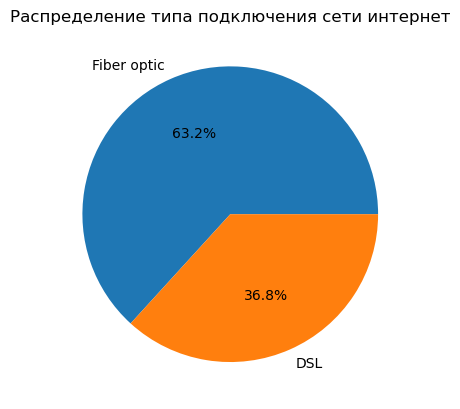

In [72]:
# Построим круговую диаграмму распределения типа подключения сети интернет абонентов.
labels = ['Fiber optic','DSL']
xdata = internet_left['InternetService'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Распределение типа подключения сети интернет')
plt.show()

**Описание данных:** Видим, что среди ушедших пользователей было больше подключенных по оптоволокну.

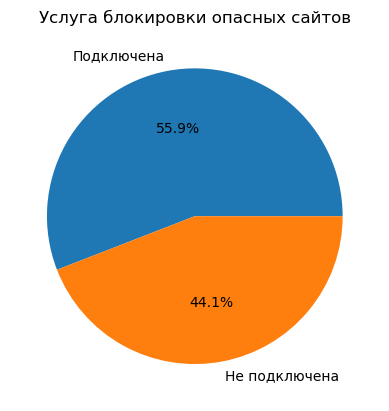

In [73]:
# Построим круговую диаграмму распределения использования услуги блокировки опасных сайтов.
labels = ['Подключена','Не подключена']
xdata = internet_left['OnlineSecurity'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуга блокировки опасных сайтов')
plt.show()

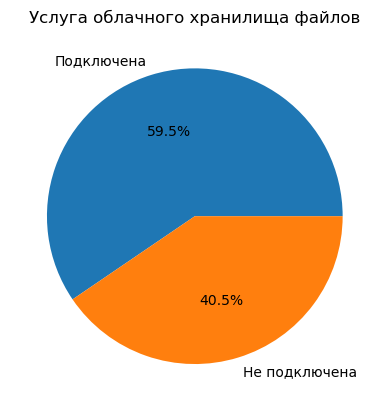

In [74]:
# Построим круговую диаграмму распределения использования услуги облачного хранилища файлов.
labels = ['Подключена','Не подключена']
xdata = internet_left['OnlineBackup'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуга облачного хранилища файлов')
plt.show()

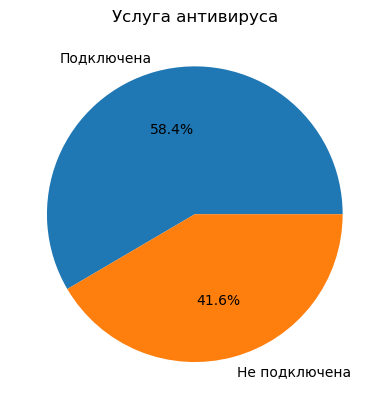

In [75]:
# Построим круговую диаграмму распределения использования услуги антивируса.
labels = ['Подключена','Не подключена']
xdata = internet_left['DeviceProtection'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуга антивируса')
plt.show()

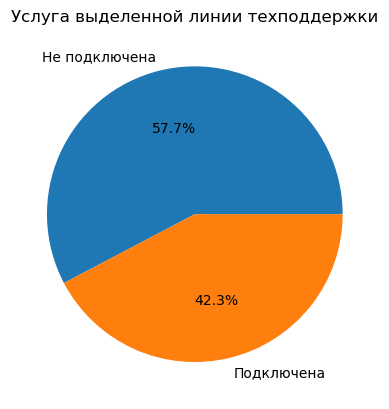

In [76]:
# Построим круговую диаграмму распределения использования услуги выделенной линии техподдержки.
labels = ['Не подключена','Подключена']
xdata = internet_left['TechSupport'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуга выделенной линии техподдержки')
plt.show()

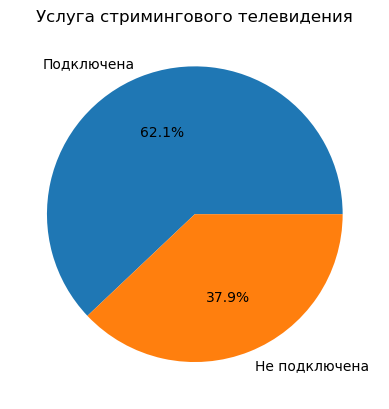

In [77]:
# Построим круговую диаграмму распределения использования услуги стримингового телевидения.
labels = ['Подключена','Не подключена']
xdata = internet_left['StreamingTV'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуга стримингового телевидения')
plt.show()

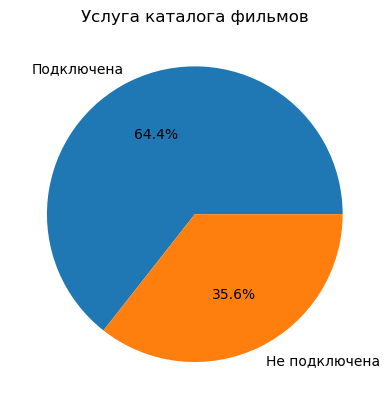

In [78]:
# Построим круговую диаграмму распределения использования услуги каталога фильмов.
labels = ['Подключена','Не подключена']
xdata = internet_left['StreamingMovies'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуга каталога фильмов')
plt.show()

**Описание данных:** Видим, что ушедшие пользователи пользовались всеми услугами больше среднего.

#### Услуги телефонии

In [79]:
phone_left = contract.merge(phone, on='customerID', how='left')
phone_left = phone_left.loc[phone_left['terminated'] == 1]
phone_left = phone_left.dropna()

In [80]:
phone_left.describe(include='all')

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,terminated,duration,MultipleLines,phone
count,998,998,998,998,998.000000,998.000000,998.0,998.000000,998,998
unique,998,3,2,4,NaN,NaN,NaN,NaN,2,1
top,6388-TABGU,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,Yes,Yes
freq,1,369,655,319,NaN,NaN,NaN,NaN,678,998
mean,NaN,NaN,NaN,NaN,78.571092,2469.505601,1.0,928.789579,NaN,NaN
std,NaN,NaN,NaN,NaN,28.757300,1608.995946,0.0,461.419842,NaN,NaN
min,NaN,NaN,NaN,NaN,18.400000,77.840000,1.0,28.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,67.050000,1103.600000,1.0,578.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,86.025000,2270.365000,1.0,914.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,100.200000,3581.550000,1.0,1277.000000,NaN,NaN


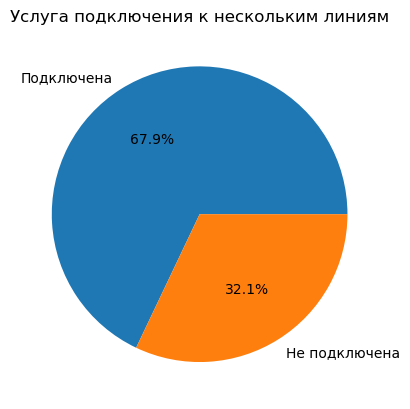

In [81]:
# Построим круговую диаграмму распределения подключения телефона к нескольким линиям одновременно.
labels = ['Подключена','Не подключена']
xdata = phone_left['MultipleLines'].value_counts()
plt.pie(x=xdata, autopct="%.1f%%", labels=labels)
plt.title('Услуга подключения к нескольким линиям')
plt.show()

**Описание данных:** Видим, что ушедшие пользователи пользовались услугой больше среднего.

**Промежуточный вывод:** Подытожим портрет ушедшего абонента:

- Меньше среднего платящих ежемесячно;
- Больше оплачивающих онлайн, получающих электронные чеки;
- Больше в среднем затрат, больше среднего пользователей дополнительных услуг;
- Больше среднего абонентов с договором, действующим дольше года;
- Больше среднего абонентов с партнёром, пенсионеров.

Исходя из графического сравнения портрета ушедшего абонента со средними значениями, можно предположить, что отток вызван ценами на услуги, возможно из-за назойливого подключения дополнительных услуг или сравнительно высокой ценой. Возможно даже переманивание конкурентами, судя по разнице способов оплаты, через интернет.

### Корреляционный анализ

In [82]:
# Воспользуемся тепловой картой, чтобы построить таблицу коэффициентов корреляции
# признаков тренировочной выборки.
cdf = data.drop(columns=['customer_id'])

# Составим список интервальных признаков.
interval_cols = ['monthly_charges', 'total_charges', 'duration']

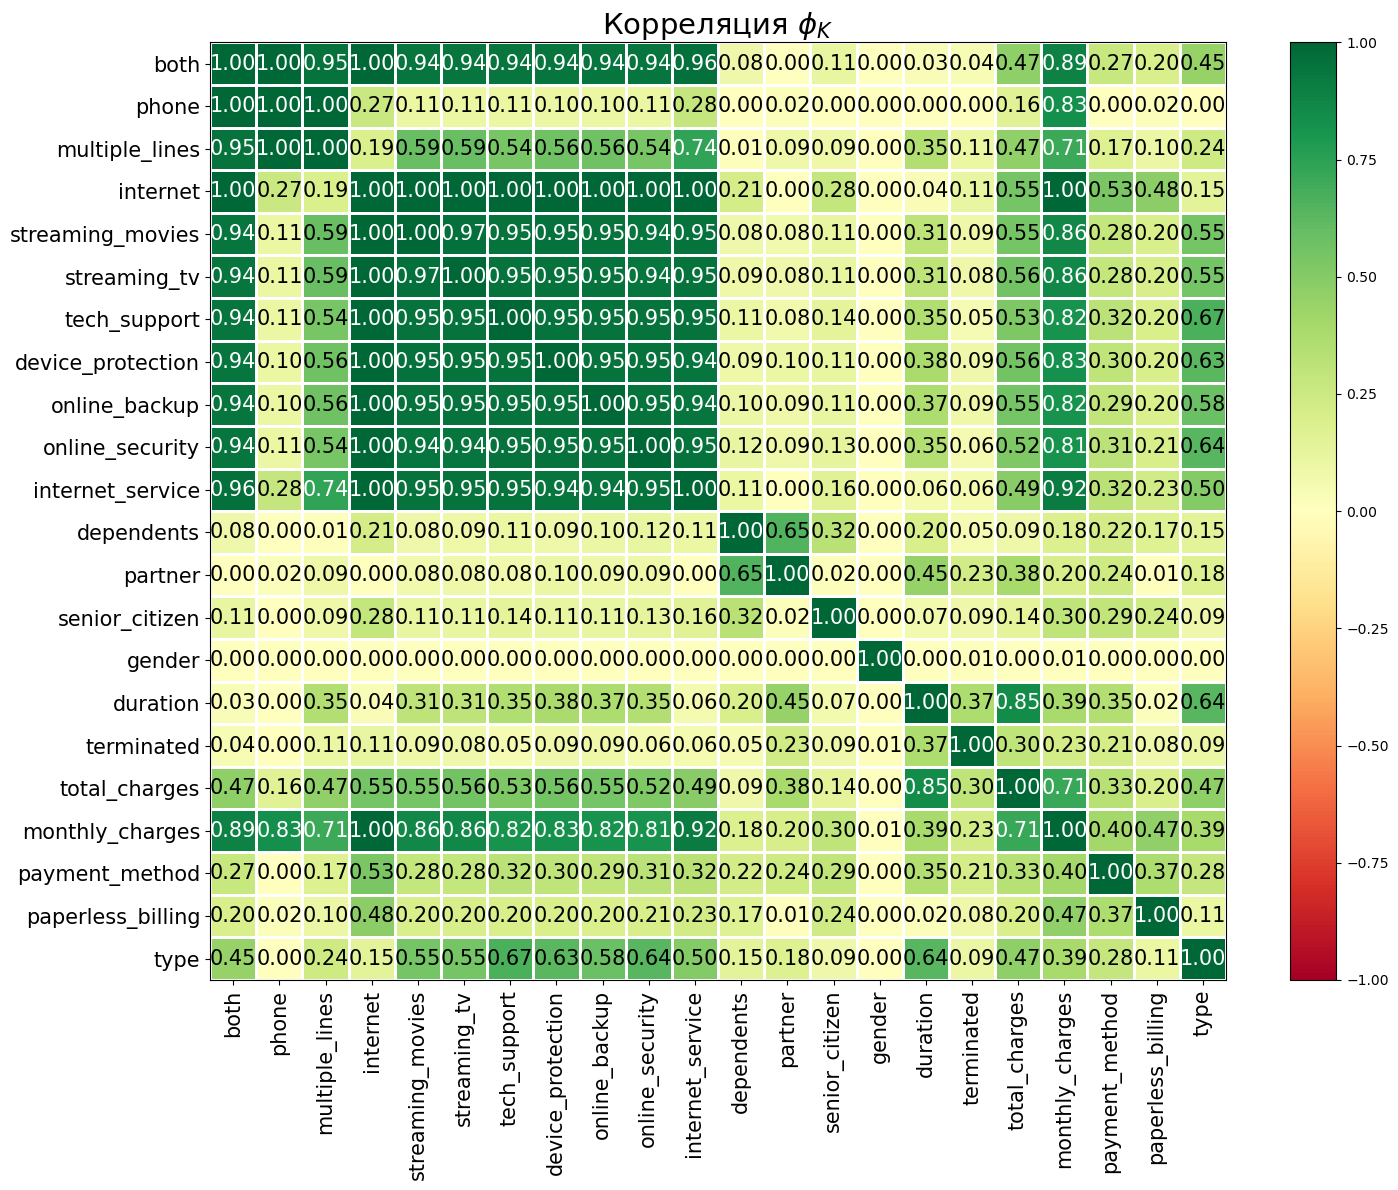

In [83]:
# Вычислим коэффициенты корреляции phi для датафрейма.
phik_overview = cdf.phik_matrix(interval_cols=interval_cols)

# Визуализируем тепловую карту коэффициентов корреляции.
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Корреляция $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Описание данных:** Видим корреляцию между наличием интернета/телефона в договоре абонента и соответствующими услугами, а также между самими услугами. Также наблюдается сильная корреляция между помесячной оплатой и наличием и типом интернет услуг.

Кроме того, изучая корреляцию целевого признака, мы видим, что услуги, использование телефона, наличие детей, и пол абонента слабо влияют на расторжение им договора.

**Промежуточный вывод:** Корреляционный анализ целевого признака опровергает теории из графического анализа. Наибольшая корреляция - с длительностью, ценами и способом оплаты, что может значить, что пользователи покидают оператора из-за роста цен на те же услуги или окончания акционного периода.

## Подготовка данных

In [84]:
# Уберём низкокоррелирующие с целевым признаки и признаки, сильно коррелирущие друг с другом.
df = cdf.drop(columns=['both', 'phone', 'gender'])
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,terminated,duration,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,None
1,One year,No,Mailed check,56.95,2071.84,0,1036,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,None
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No


In [85]:
# Разделим данные на обучающую и тестовую выборки.
# Стратифицируем выборки, чтобы избежать недостатка целевого признака в одной из них.
X = df.drop(['terminated'], axis=1)
y = df['terminated']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [86]:
# Уточним, какие признаки категоральные, а какие - количественные.
cat_col_names = ['type', 'paperless_billing', 'payment_method', 'senior_citizen',
                 'partner', 'dependents', 'internet_service', 'online_security',
                 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
                 'streaming_movies', 'internet', 'multiple_lines']
num_col_names = ['monthly_charges', 'total_charges', 'duration']

# Масштабируем количественные признаки с помощью стандартизации.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

# Закодируем категоральные признаки.
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

# Cоздадим тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных.
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# Объединим все преобразованные данные в тренировочный и тестовый датафреймы.
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

**Промежуточный вывод:** Данные разделены на стратифицированные обучающую и тестовую выборки. Произведены масштабирование количественных и кодировка категоральных признаков.

## Обучение моделей машинного обучения

### LogisticRegression

In [87]:
%%time

# Инициализируем модель логистической регрессии.
model_lr = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

# Воспользуемся GridSearchCV для кросс-валидации модели.
param_lr = {'C': [0.5, 1],
            'solver': ['liblinear', 'saga']}
grid_lr = GridSearchCV(model_lr, param_lr, scoring='roc_auc', cv=3, n_jobs=-1, verbose=3)
grid_lr.fit(X_train, y_train)

print('Лучшие параметры логистической регрессии:', grid_lr.best_params_)
print('ROC-AUC логистической регрессии:', grid_lr.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие параметры логистической регрессии: {'C': 0.5, 'solver': 'saga'}
ROC-AUC логистической регрессии: 0.765955285122807
CPU times: total: 125 ms
Wall time: 519 ms


C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Промежуточный вывод:** ROC-AUC логистической регрессии = 0.77, что не удовлетворяет заданному условию.

### RandomForestClassifier

In [88]:
%%time

# Инициализируем модель случайного леса.
model_rf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

# Воспользуемся GridSearchCV для кросс-валидации модели.
param_rf = {'max_depth' : [5, 10],
            'n_estimators': [150, 200]}
grid_rf = GridSearchCV(model_rf, param_rf, scoring='roc_auc', cv=3, n_jobs=-1, verbose=3)
grid_rf.fit(X_train, y_train)

print('Лучшие параметры случайного леса:', grid_rf.best_params_)
print('ROC-AUC случайного леса:', grid_rf.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие параметры случайного леса: {'max_depth': 10, 'n_estimators': 150}
ROC-AUC случайного леса: 0.81198671771793
CPU times: total: 500 ms
Wall time: 1.36 s


**Промежуточный вывод:** ROC-AUC случайного леса = 0.81, что не удовлетворяет заданному условию.

### LightGBM

In [89]:
%%time

# Инициализируем модель LightGBM.
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, objective='binary', is_unbalance=True)

# Зададим параметры и воспользуемся GridSearchCV для определения лучших по метрике.
param_lgbm = {'max_depth': [2, 3],
              'num_leaves': [3, 4],
              'n_estimators': [1500, 2000],
              'reg_alpha': [0.1, 0.2]}
grid_lgbm = GridSearchCV(model_lgbm, param_lgbm, scoring='roc_auc', cv=3, n_jobs=-1, verbose=0)
grid_lgbm.fit(X_train, y_train)

print('Лучшие параметры LightGBM:', grid_lgbm.best_params_)
print('ROC-AUC LightGBM:', grid_lgbm.best_score_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 826, number of negative: 4448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 5274, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156617 -> initscore=-1.683615
[LightGBM] [Info] Start training from score -1.683615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

**Промежуточный вывод:** ROC-AUC LightGBM = 0.89, что удовлетворяет заданному условию.

## Выбор лучшей модели

Исходя из оценки метрики, остановимся на ***LightGBM***, как лучшей по ROC-AUC. Проверим её качество на тестовой выборке.

In [90]:
# Протестируем наилучшую модель на тестовой выборке.
model = LGBMClassifier(random_state=RANDOM_STATE, objective='binary', is_unbalance=True,
                       max_depth=2, n_estimators = 2000, num_leaves=4, reg_alpha = 0.2)
model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)[:, 1]
best_score = roc_auc_score(y_test, predictions)

print('ROC-AUC для лучшей модели LightGBM:', best_score)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 826, number of negative: 4448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 5274, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156617 -> initscore=-1.683615
[LightGBM] [Info] Start training from score -1.683615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

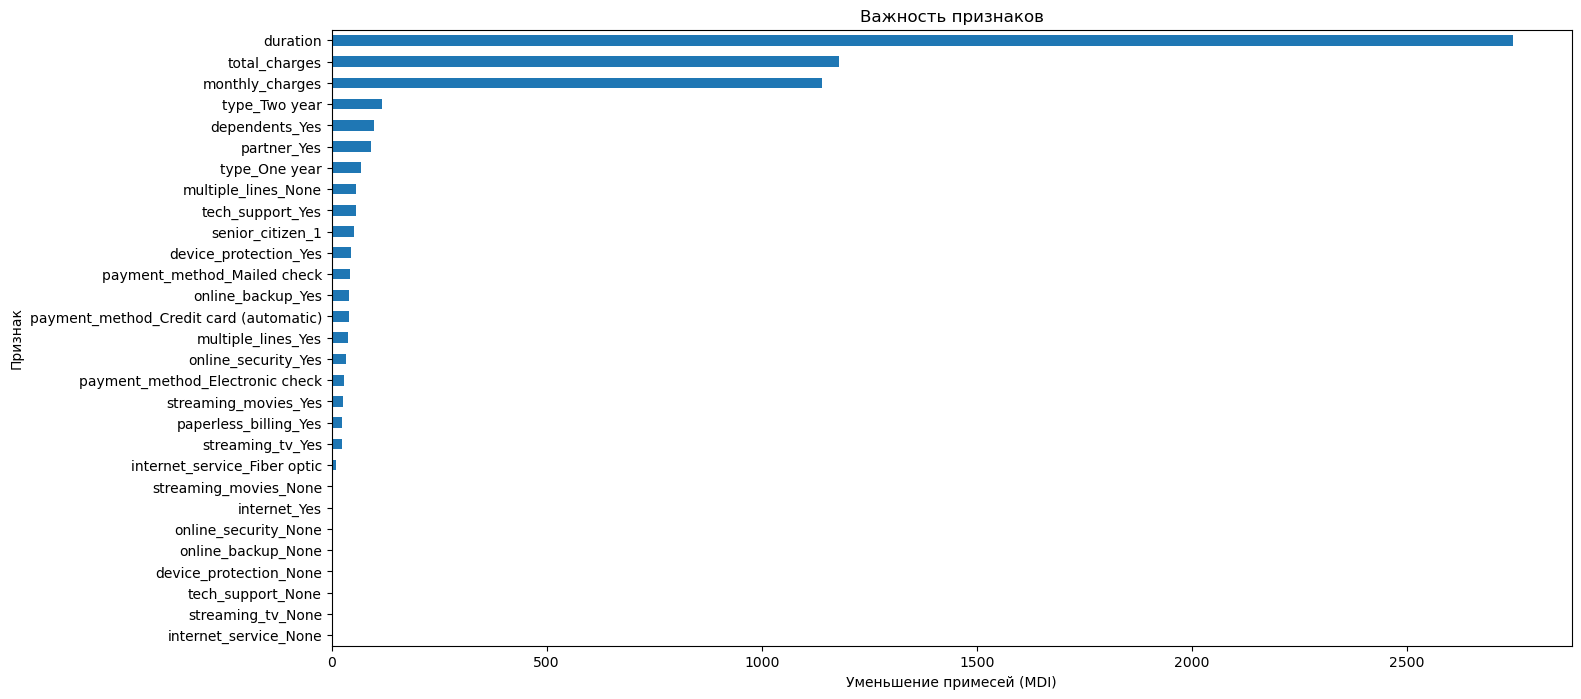

In [91]:
# Построим график важности признаков для лучшей модели.
feature_names = X_train.columns.to_list()
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names).sort_values()

plt.figure(figsize=(16,8))
model_importances.plot(kind='barh')
plt.title('Важность признаков')
plt.xlabel('Уменьшение примесей (MDI)')
plt.ylabel('Признак')
plt.show()

**Промежуточный вывод:** Видим, что самыми важными признаками для модели являются длительность договора, тип платежа и расходы абонента.

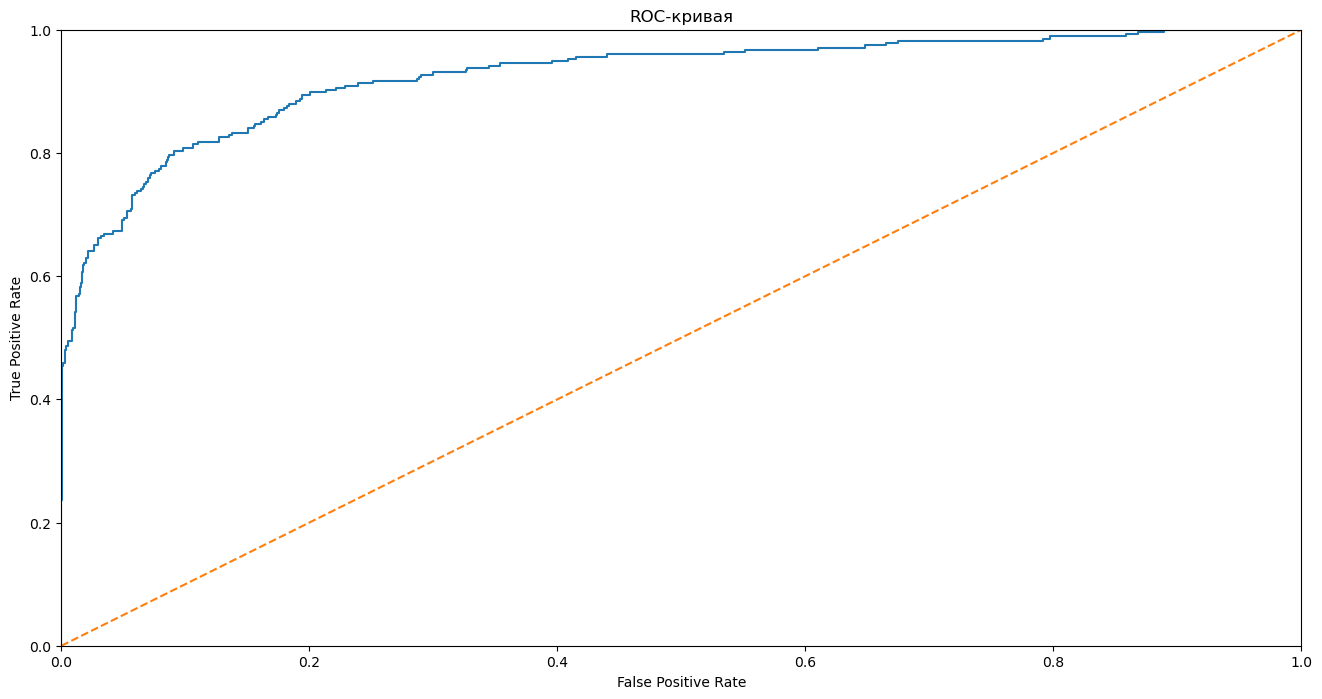

In [92]:
# Построим график ROC-кривой для лучшей модели.
fpr, tpr, thresholds = roc_curve(y_test, predictions)

plt.figure(figsize=(16,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

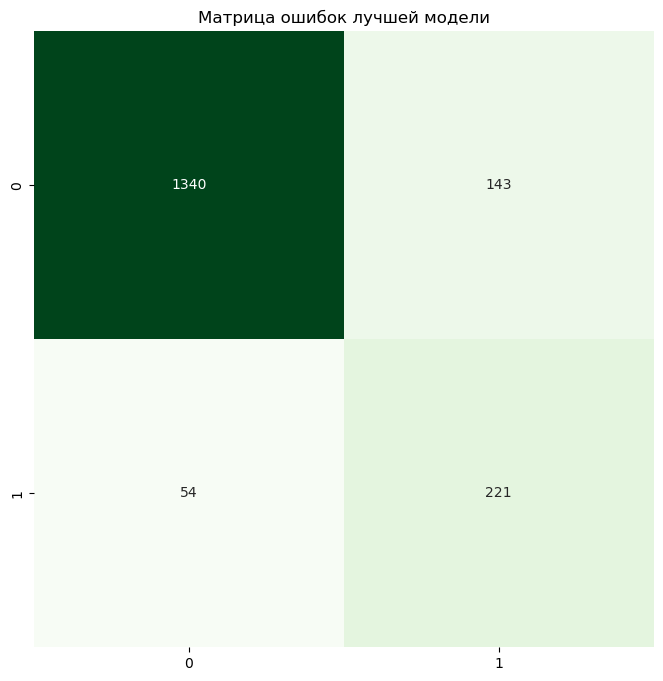

In [93]:
# Построим матрицу ошибок лучшей модели.
y_pred = np.where(predictions > 0.5, 1, 0)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap= 'Greens', cbar=False, fmt='d')
plt.title('Матрица ошибок лучшей модели')
plt.show()

**Промежуточный вывод:** ROC-AUC LightGBM на тестовой выборке = 0.93. Матрица ошибок показывает, что модель допускает большее количество ошибок типа False Positive, чем типа False Negative. Однако, проигнорированный и ушедший абонент - это хуже, чем абонент, получивший скидку, в плане выручки.

## Общий вывод

***Цель исследования:*** Построили модели машинного обучения для прогноза оттока клиентов. Оценили их по критериям, указанным заказчиком.

***Исследовательский анализ и предобработка данных:*** В результате предобработки данных сгенерировали 2 новых признака взамен 2 старых: один из них - целевой(terminated - состояние договора), другой(duration - длительность договора) объединяет в себе два старых признака для более удобного анализа. Также добавили 2 признака использования абонентом интернета и телефона для дальнейшей работы.

Провели графический исследовательский анализ данных. Выявили несбалансированность целевого признака, посмотрели, какие данные потребуют обработки перед обучением моделей.

***Исследовательский анализ и предобработка данных объединённого датафрейма:*** В результате объединения данных добавили и дополнили новые признаки. Указали их правильные типы.

Составили портрет ушедшего абонента:

- Меньше среднего платящих ежемесячно;
- Больше оплачивающих онлайн, получающих электронные чеки;
- Больше в среднем затрат, больше среднего пользователей дополнительных услуг;
- Больше среднего абонентов с договором, действующим дольше года;
- Больше среднего абонентов с партнёром, пенсионеров.

Провели графическое сравнение данных о разорвавших договор клиентах с общими. Изначально предположили, что отток вызван ценами на услуги, возможно из-за назойливого подключения дополнительных услуг или сравнительно высокой ценой. Возможно даже переманивание конкурентами, судя по разнице способов оплаты, через интернет.

Однако, корреляционный анализ целевого признака опроверг теории из графического анализа. Наибольшая корреляция оттока клиентов - с длительностью, ценами и способом оплаты, что может значить, что пользователи покидают оператора из-за роста цен на те же услуги или окончания акционного периода. Сами по себе услуги, использование телефона, наличие детей, и пол абонента слабо влияют на расторжение им договора.

***Подготовка данных:*** Данные разделены на стратифицированные обучающую и тестовую выборки. Произведены масштабирование количественных и кодировка категоральных признаков.

***Обучение моделей машинного обучения:*** Обучили 3 модели машинного обучения: LogisticRegression, RandomForestClassifier, LightGBM. Подобрали гиперпараметры и учли дизбаланс классов.

***Выбор лучшей модели:*** Исходя из оценки метрики, остановились на LightGBM, как лучшей по ROC-AUC. Проверили её качество на тестовой выборке. ROC-AUC для лучшей модели LightGBM: 0.93. Матрица ошибок показала, что модель допускает большее количество ошибок типа False Positive, чем типа False Negative. Однако, проигнорированный и ушедший абонент - это хуже, чем абонент, получивший скидку, в плане выручки.

***Рекомендации заказчику:*** Исходя из графического анализа, рекомендуется сравнить цены на дополнительные услуги с конкурентами.

Исходя из корреляционного анализа, следует обратить особое внимание на группу людей в не пенсионном возрасте с партнёром без детей. Также, возможно стоит что-то противопоставить переманиванию абонентов через интернет. Кроме того, рекомендуется сгладить рост сцен, особенно при окончании акционного периода (если таковой имеется).